In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout

##Import any other packages you may need here

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_xray_df.sample(3)



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
103563,00027643_000.png,No Finding,0,27643,28,F,AP,3056,2544,0.139,0.139,NaN
90327,00022458_003.png,No Finding,3,22458,19,M,AP,3056,2544,0.139,0.139,NaN
104803,00028087_000.png,No Finding,0,28087,64,M,PA,2992,2991,0.143,0.143,NaN


In [4]:
data_sample = pd.read_csv('/kaggle/input/sample-labels-of-nih-dataset/sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4158,00020415_001.png,Infiltration,1,20415,045Y,F,PA,2992,2991,0.143,0.143
1210,00006391_000.png,Infiltration,0,6391,009Y,M,AP,2500,2048,0.171,0.171
5380,00029039_004.png,No Finding,4,29039,061Y,M,AP,3056,2544,0.139,0.139


In [5]:
print(f'all xray shape: {all_xray_df.shape}')
print(f'data sample shape: {data_sample.shape}\n')
print(all_xray_df.columns)
print(data_sample.columns)

all xray shape: (112120, 12)
data sample shape: (5606, 11)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y'],
      dtype='object')


## Frequency of each disease in the dataset

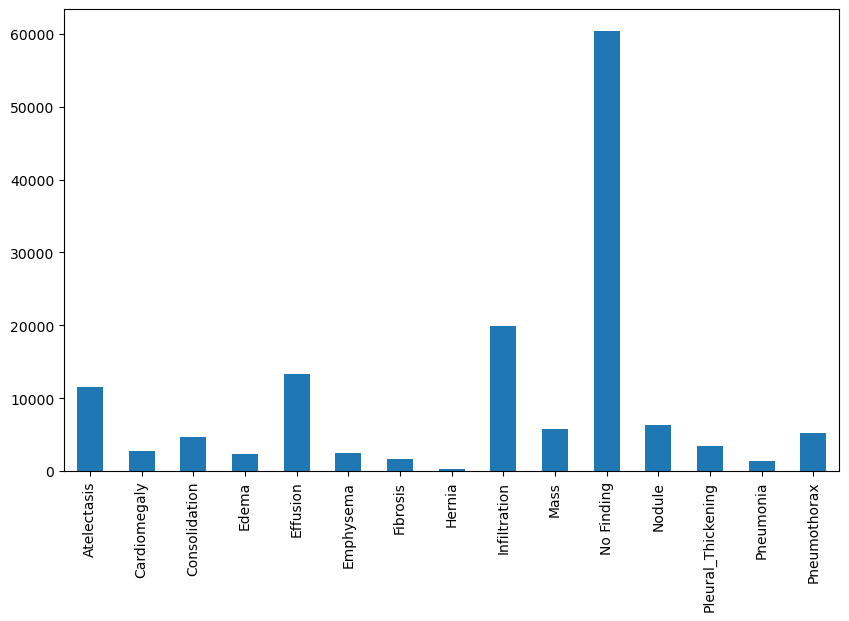

In [6]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
hot_encoded_xray = all_xray_df.copy()
for label in all_labels:
    hot_encoded_xray[label] = hot_encoded_xray["Finding Labels"].map(lambda x: 1 if label in x else 0)
    
plt.figure(figsize=(10, 6))
ax = hot_encoded_xray[all_labels].sum().plot(kind='bar')

## Patient with Pneumonia

In [7]:
pneumonia_xray = hot_encoded_xray[hot_encoded_xray['Pneumonia'] == 1]
pneumonia_xray.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,1
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,1,0,1,0
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,1,1,0
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,0


## how frequently pneumonia appears with other disease

<Axes: >

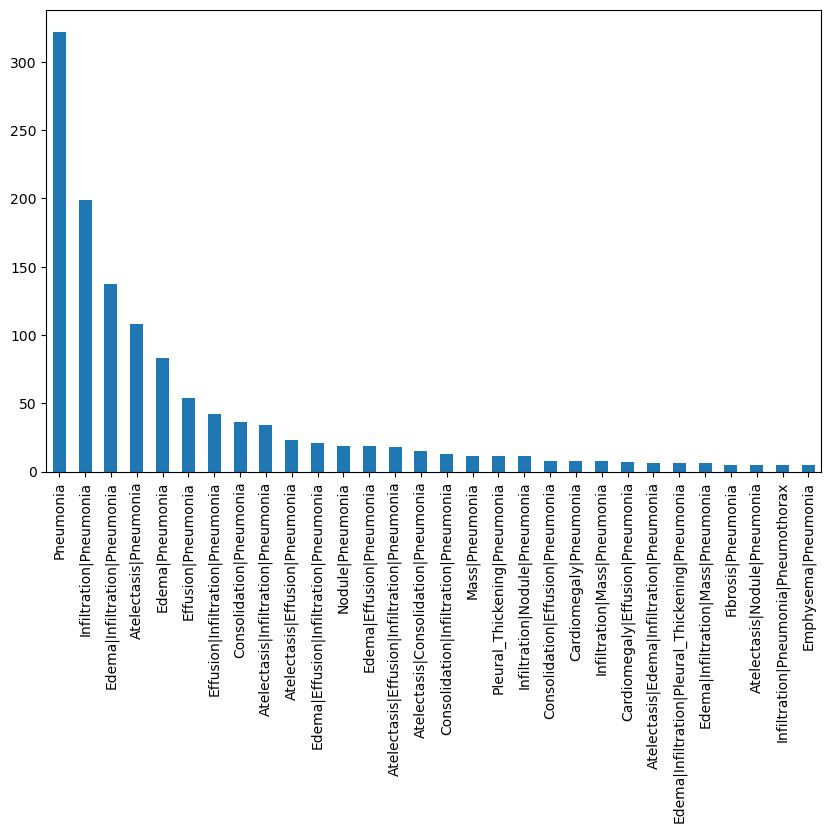

In [8]:
plt.figure(figsize=(10, 6))
pneumonia_xray["Finding Labels"].value_counts()[:30].plot(kind='bar')

## distribution of the age across the dataset

min age : 2
max age : 412
mean age : 44.67062937062937


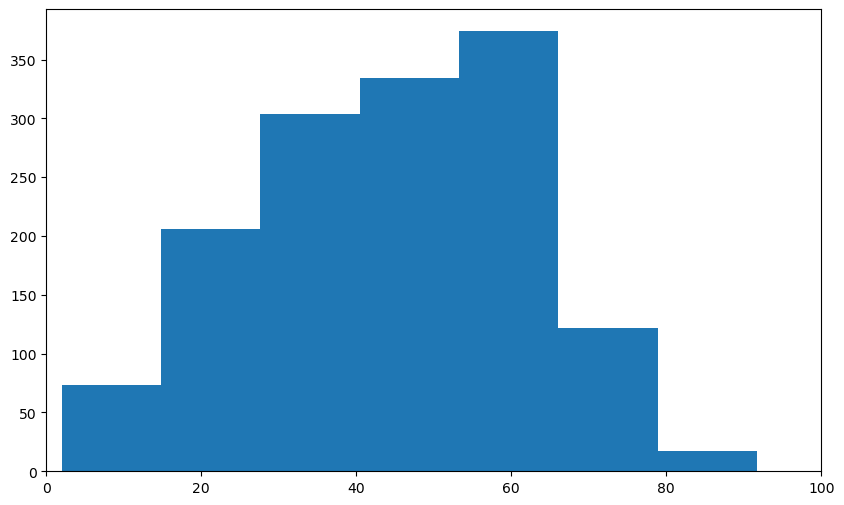

In [9]:
print(f'min age : {pneumonia_xray["Patient Age"].min()}')
#we have and outlier patient age = 412
print(f'max age : {pneumonia_xray["Patient Age"].max()}')
print(f'mean age : {pneumonia_xray[pneumonia_xray["Patient Age"] <= 90]["Patient Age"].mean()}')
plt.figure(figsize=(10, 6))
plt.hist(pneumonia_xray['Patient Age'], bins=32)
plt.xlim((0,100))
plt.show()

## distribution of gender across the dataset

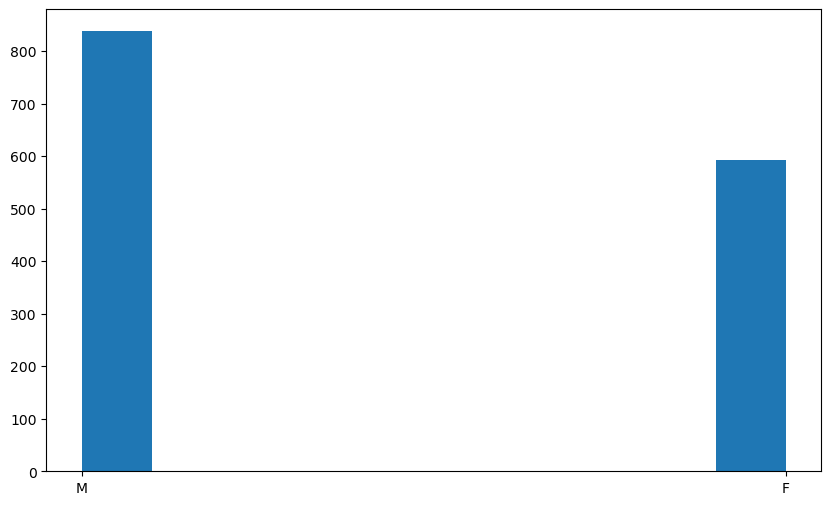

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(pneumonia_xray['Patient Gender'])
plt.show()

In [11]:
all_labels


array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [12]:
diseases = []
for label in all_labels:
    if label != "Pneumonia":
        disease = hot_encoded_xray[hot_encoded_xray["Finding Labels"] == label]
        diseases.append(disease)
        print(f"{label}:{len(disease)}")

Atelectasis:4215
Cardiomegaly:1093
Consolidation:1310
Edema:628
Effusion:3955
Emphysema:892
Fibrosis:727
Hernia:110
Infiltration:9547
Mass:2139
No Finding:60361
Nodule:2705
Pleural_Thickening:1126
Pneumothorax:2194


In [13]:
no_pneumonia_list = []
for label, disease in zip(all_labels, diseases):
    if(label == 'No Finding'):
        no_pneumonia_list.append(disease.sample(121))
    elif(label != 'Hernia'):
        no_pneumonia_list.append(disease.sample(100))
    else:
        no_pneumonia_list.append(disease)
        
len(no_pneumonia_list)      

14

In [14]:
# no_pneumonia_xray = pd.concat(no_pneumonia_list)
no_pneumonia_xray = hot_encoded_xray[hot_encoded_xray["Finding Labels"] == 'No Finding'].sample(1431)
print(f'length of pneumonia sample: {no_pneumonia_xray.shape[0]}')
print(f'length of no pneumonia sample: {pneumonia_xray.shape[0]}')

length of pneumonia sample: 1431
length of no pneumonia sample: 1431


In [15]:
all_image_paths = {os.path.basename(x): x for x in glob("/kaggle/input/data/images*/*/*.png")}
pneumonia_xray['path'] = pneumonia_xray['Image Index'].map(all_image_paths.get)
no_pneumonia_xray['path'] = no_pneumonia_xray['Image Index'].map(all_image_paths.get)
pneumonia_xray['pneumonia_class'] = "yes"
no_pneumonia_xray['pneumonia_class'] = "no"

/tmp/ipykernel_29/622432922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pneumonia_xray['path'] = pneumonia_xray['Image Index'].map(all_image_paths.get)
/tmp/ipykernel_29/622432922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pneumonia_xray['pneumonia_class'] = "yes"


In [16]:
IMG_SIZE=(224, 224)

def create_split(pneumonia, no_pneumonia):
    #shuffle data
    pneumonia = pneumonia.sample(frac=1)
    no_pneumonia = no_pneumonia.sample(frac=1)
    
    #data size
    train_size = int(pneumonia.shape[0] * 0.8)
    val_size = pneumonia.shape[0] - train_size
    
    train_data = pd.concat([pneumonia[:train_size], no_pneumonia[:train_size]]).sample(frac=1)
    val_data = pd.concat([pneumonia[train_size:], no_pneumonia[train_size:]]).sample(frac=1)
    
    return train_data, val_data



def train_gen(data):
    idg = ImageDataGenerator(
                            horizontal_flip=True, 
                            vertical_flip=False,
                            height_shift_range=0.1,
                            width_shift_range=0.1,
                            rotation_range=20, 
                            shear_range=0.1, 
                            zoom_range=0.1,
                            fill_mode='reflect',
                            samplewise_center=True,
                            samplewise_std_normalization=True)
    train_gen = idg.flow_from_dataframe(dataframe=data, 
                                       directory=None, 
                                       x_col='path', 
                                       y_col='pneumonia_class',
                                       class_mode='binary', 
                                       target_size=IMG_SIZE, 
                                       batch_size=64, 
                                       shuffle=True)
    

    return train_gen

def val_gen(data):
    val_gen = ImageDataGenerator(samplewise_std_normalization=True,
                                samplewise_center=True).flow_from_dataframe(dataframe=data, 
                                                      directory=None, 
                                                      x_col='path', 
                                                      y_col='pneumonia_class', 
                                                      class_mode='binary', 
                                                      target_size=IMG_SIZE, 
                                                      batch_size=64)
    return val_gen

In [17]:
train_data, val_data = create_split(pneumonia_xray, no_pneumonia_xray)
print(train_data.shape)
print(val_data.shape)


(2288, 29)
(574, 29)


Found 2288 validated image filenames belonging to 2 classes.
Found 574 validated image filenames belonging to 2 classes.


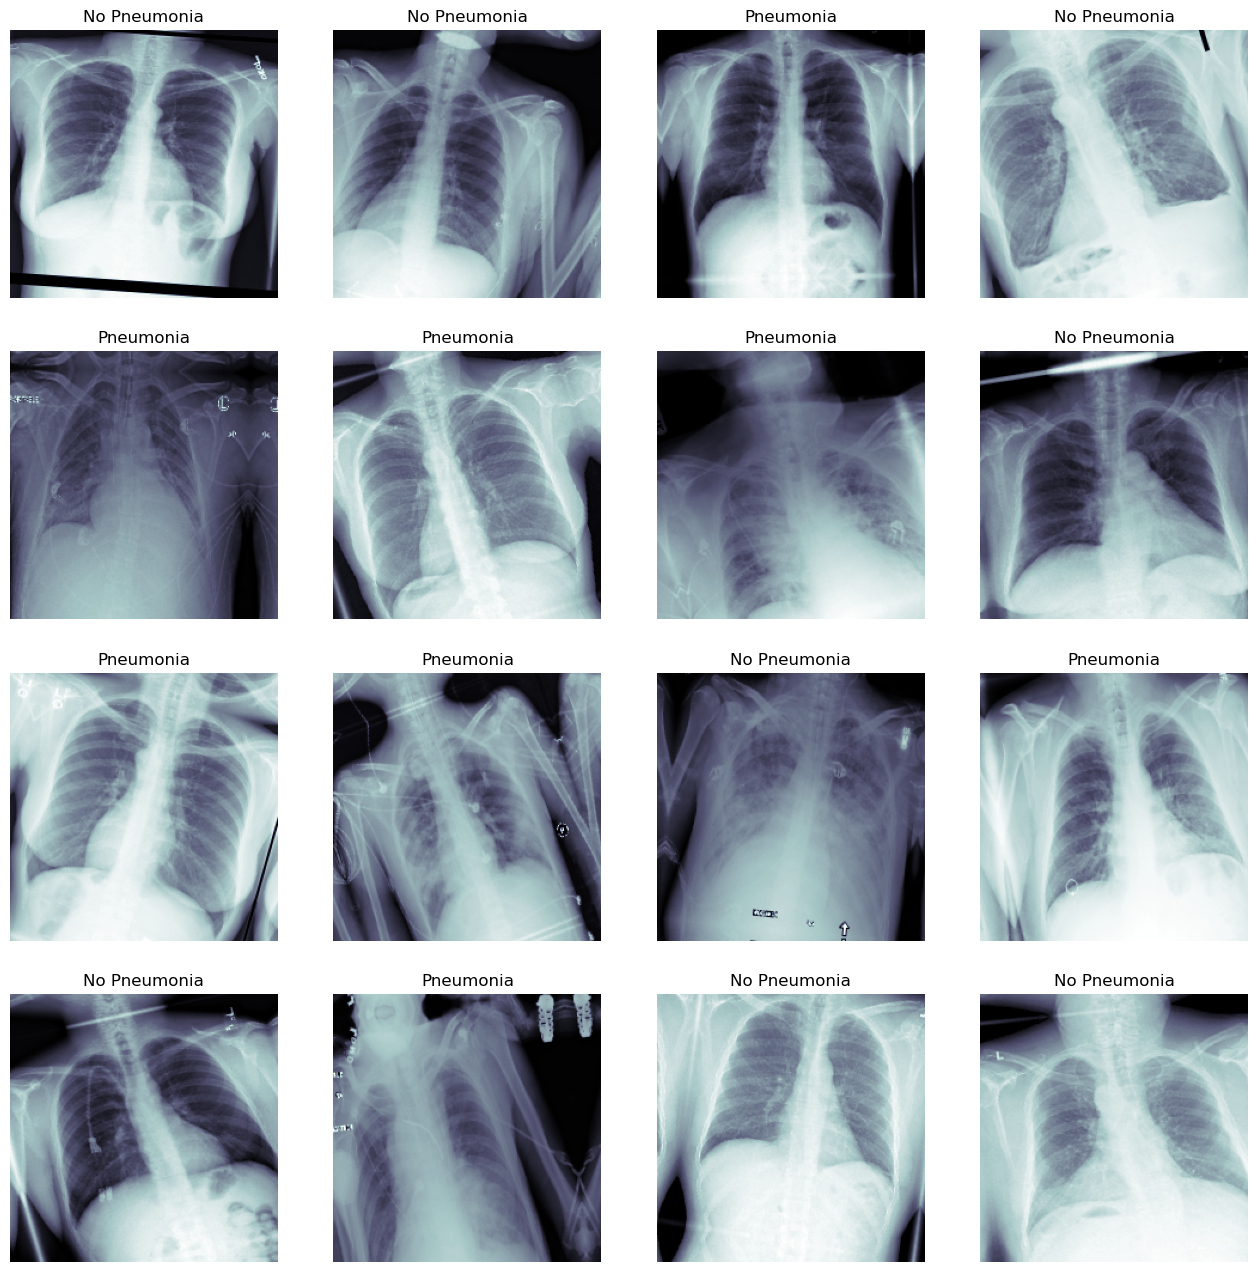

In [18]:
train_gen = train_gen(train_data)
val_gen = val_gen(val_data)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

# Load Pretrained Model

In [19]:
model = VGG16(include_top=True, weights="imagenet")
model.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

# freeze vgg weights
for layer in vgg_model.layers[:17]:
    layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False


# build the model

In [21]:
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [22]:
my_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])
history = my_model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
36/36 [==============================] - 124s 3s/step - loss: 0.9414 - binary_accuracy: 0.5695 - val_loss: 0.6327 - val_binary_accuracy: 0.6829
Epoch 2/10
36/36 [==============================] - 71s 2s/step - loss: 0.6285 - binary_accuracy: 0.6582 - val_loss: 0.5989 - val_binary_accuracy: 0.6568
Epoch 3/10
36/36 [==============================] - 71s 2s/step - loss: 0.6190 - binary_accuracy: 0.6766 - val_loss: 0.6103 - val_binary_accuracy: 0.6742
Epoch 4/10
36/36 [==============================] - 76s 2s/step - loss: 0.6002 - binary_accuracy: 0.6954 - val_loss: 0.5631 - val_binary_accuracy: 0.7213
Epoch 5/10
36/36 [==============================] - 83s 2s/step - loss: 0.5890 - binary_accuracy: 0.7142 - val_loss: 0.5807 - val_binary_accuracy: 0.7230
Epoch 6/10
36/36 [==============================] - 72s 2s/step - loss: 0.5863 - binary_accuracy: 0.7032 - val_loss: 0.5883 - val_binary_accuracy: 0.7108
Epoch 7/10
36/36 [==============================] - 71s 2s/step - loss: 0.5

In [23]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


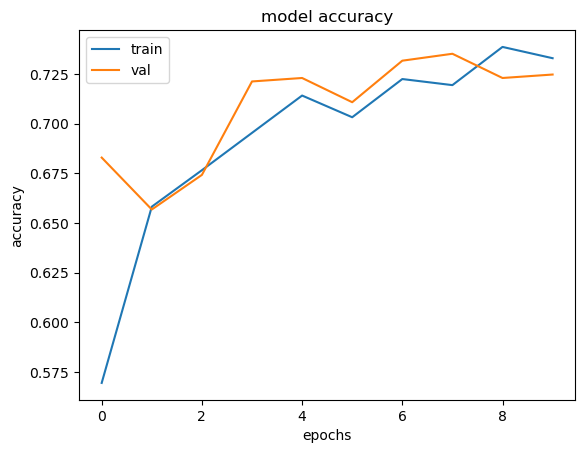

In [25]:

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("model accuracy")
plt.xlabel('epochs')
plt.ylabel("accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()


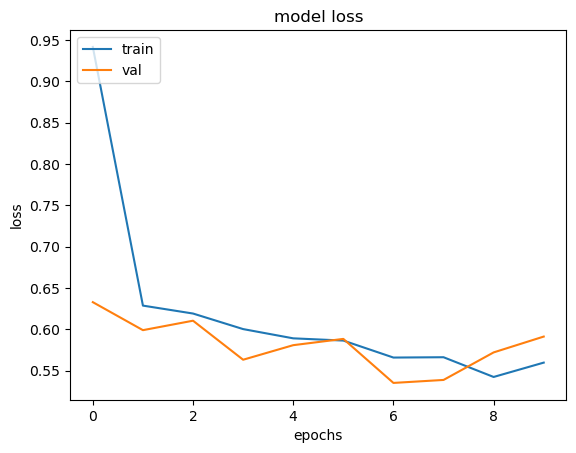

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')